<a href="https://colab.research.google.com/github/KiralyOr/PBP/blob/main/BPtoBN_transition_dist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pgmpy

In [ ]:
from collections import defaultdict
import itertools
import graphviz
import pandas as pd
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD


#BThreds implementation


###Data Structure definition

In [ ]:
INITIALS=defaultdict(list,
            {'bt1': {'states':['0'], 'dist':[1]},
             'bt2': {'states':['0'], 'dist':[]},
             'bt3': {'states':['0'], },})

BTHREADS= ['bt1','bt2','bt3' ]

assert BTHREADS == list(INITIALS.keys()) 

EVENTS = ['_nop', 'g1', 'g2', 'g3', 'h1', 'h2', 'h3', 'o1', 'o2', 'o3'] 

STATES = defaultdict(list,
            {'bt1':['0','1','2','3'],
             'bt2':['0','1','2','3'],
             'bt3':['0','1','2','3']})

for bt in BTHREADS:
    assert [state in STATES[bt] for state in INITIALS[bt]['states']][0] 



REQUESTED_AND_BLOCKED = {'bt1':{'0':{'requested':['h1', 'h2', 'h3'], 'blocked': []},
                                '1':{'requested':['g1', 'g2', 'g3'], 'blocked': []},
                                '2':{'requested':['o1', 'o2', 'o3'], 'blocked': []},
                                '3':{'requested':[], 'blocked': []},
                                },
                         'bt2':{'0':{'requested':[], 'blocked': []},
                                '1':{'requested':[], 'blocked': ['o1']},
                                '2':{'requested':[], 'blocked': ['o2']},
                                '3':{'requested':[], 'blocked': ['o3']},
                                },
                         'bt3':{'0':{'requested':[], 'blocked': []},
                                '1':{'requested':[], 'blocked': ['o1']},
                                '2':{'requested':[], 'blocked': ['o2']},
                                '3':{'requested':[], 'blocked': ['o3']},
                                },
                         
                        }
                  
TRANSITIONS = {'bt1':{'transitions':[{'source':'0', 'target':'1', 'event': 'h1'},
                                     {'source':'0', 'target':'1', 'event': 'h2'}, 
                                     {'source':'0', 'target':'1', 'event': 'h3'},
                                     {'source':'1', 'target':'2', 'event': 'g1'},
                                     {'source':'1', 'target':'2', 'event': 'g2'},
                                     {'source':'1', 'target':'2', 'event': 'g3'},
                                     {'source':'2', 'target':'3', 'event': 'o1'},
                                     {'source':'2', 'target':'3', 'event': 'o2'},
                                     {'source':'2', 'target':'3', 'event': 'o3'}
                                    ]
                      ,'prob':[1 for _ in range(9)]}

              ,'bt2':{'transitions':[{'source':'0', 'target':'1', 'event': 'h1'},
                                     {'source':'0', 'target':'2', 'event': 'h2'},
                                     {'source':'0', 'target':'3', 'event': 'h3'},
                                    ]
                      ,'prob':[1 for _ in range(3)]}
              ,'bt3':{'transitions':[{'source':'0', 'target':'1', 'event': 'g1'},
                                     {'source':'0', 'target':'2', 'event': 'g2'},
                                     {'source':'0', 'target':'3', 'event': 'g3'},
                                    ]
                      ,'prob':[1 for _ in range(3)]}
               }


TIME=[0, 1, 2]

In [ ]:
{'event': 'h1', 'source': '0', 'target': '1'} in TRANSITIONS['bt1']['transitions']

True

In [ ]:
TRANSITIONS['bt1']['transitions'].index({'event': 'h1', 'source': '0', 'target': '1'})

0

# Translation to Bayesian Network

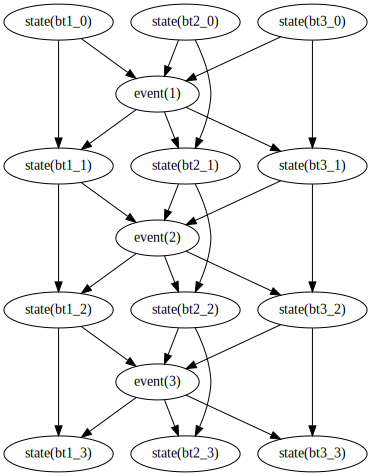

In [ ]:
p = graphviz.Digraph(name='Bayesian Network')
for i in TIME:
  for bt in BTHREADS:
    p.edge(f'event({i+1})', f'state({bt}_{i+1})')
    p.edge(f'state({bt}_{i})',f'event({i+1})')
    p.edge(f'state({bt}_{i})',f'state({bt}_{i+1})')
p

##BP util functions

In [ ]:
def requested_not_blocked(row) -> set:
  # get set of all requested not blocked  from given BP program state
  # state of each BThread in the system 
  states = [{'bt':bt,'state':row[bt]} for bt in BTHREADS]
  requested = list()
  blocked = list()
  for s in states:
      requested.extend(REQUESTED_AND_BLOCKED[s['bt']][s['state']]['requested'])
      blocked.extend(REQUESTED_AND_BLOCKED[s['bt']][s['state']]['blocked'])
  return set(requested) - set(blocked)

In [ ]:
def event_prob(event,rnb_set):
  # calculate event probability 
  # using uniform distribution for all 
  # requested not blocked events
  if event in rnb_set:
    return 1/len(rnb_set)
  elif len(rnb_set) == 0 and event == '_nop':
    return 1
  else:  
    return 0

In [ ]:
def check_no_tarnsiton(bt_name, source, event):
  # checks that there aren't any transition from given state with given event
  for target in STATES[bt_name]:
    transition = {'source':source, 'target':target, 'event':event}
    if transition in TRANSITIONS[bt_name]['transitions']:   
      return False
  return True
assert check_no_tarnsiton('bt1', '0', 'h1') == False

In [ ]:
def is_valid_transition(bt_name, source, target, event):
  # check if transition is valid using TRANSITIONS data structure
  # if the transition not exists checks if self loop should be assigend
  transition = {'source':source, 'target':target, 'event':event}
  if transition in TRANSITIONS[bt_name]['transitions']:
    i = TRANSITIONS[bt_name]['transitions'].index(transition)
    return TRANSITIONS[bt_name]['prob'][i]
  elif source == target and check_no_tarnsiton(bt_name, source, event):
    return 1
  else:   
    return 0

In [ ]:
def get_inital_state_prob(bt_name, state):
  if state in INITIALS[bt_name]['states']:
    if INITIALS[bt_name].get('prob'):
      return INITIALS[bt_name].get('prob')[INITIALS[bt_name]['states'].index(state)]
    else:
      return 1/len(INITIALS[bt_name]['states'])
  else:
      return 0      

##Create CPDs

In [ ]:
def pivot_cpd(df):
  pivot_df = pd.pivot_table(df, values='prob', index=['event'],
                    columns=BTHREADS).reset_index()                 
  return pivot_df

def get_cpd_event_table():
  states = [STATES[bt] for bt in BTHREADS]
  states.append(EVENTS)
  event_table = [p for p in itertools.product(*states)]
  columns = BTHREADS +['event']
  df = pd.DataFrame(event_table, columns=columns)
  df['prob'] = df.apply(lambda x: event_prob(x['event'], requested_not_blocked((x))), axis=1)
  # df.sort_values(by=columns)
  return pivot_cpd(df)

In [ ]:
def get_cpd_internal_state_table(bt_name):
  states = [STATES[bt_name],list(EVENTS), STATES[bt_name]]
  event_table = [p for p in itertools.product(*states)]
  columns = [bt_name , 'event', f'next_{bt_name}']
  df = pd.DataFrame(event_table, columns=columns)
  df['prob'] = df.apply(lambda x: is_valid_transition(bt_name, x[bt_name], x[f'next_{bt_name}'], x['event']) ,axis=1) 
  pivot_df = pd.pivot_table(df, values='prob', index=[f'next_{bt_name}'],
                    columns=[bt_name, 'event']).reset_index().fillna(0)
  return pivot_df

In [ ]:
def get_cpd_initial_table(bt_name):
  df = pd.DataFrame(STATES[bt_name], columns=[bt_name])
  df['prob'] = df.apply(lambda x: get_inital_state_prob(bt_name, x[bt_name]),axis=1) 
  return df

### Create cps tabels

In [ ]:
get_cpd_internal_state_table('bt3')

bt3   next_bt3    0                          ...    3                           
event          _nop g1 g2 g3 h1 h2 h3 o1 o2  ... _nop g1 g2 g3 h1 h2 h3 o1 o2 o3
0            0    1  0  0  0  1  1  1  1  1  ...    0  0  0  0  0  0  0  0  0  0
1            1    0  1  0  0  0  0  0  0  0  ...    0  0  0  0  0  0  0  0  0  0
2            2    0  0  1  0  0  0  0  0  0  ...    0  0  0  0  0  0  0  0  0  0
3            3    0  0  0  1  0  0  0  0  0  ...    1  1  1  1  1  1  1  1  1  1

[4 rows x 41 columns]

In [ ]:
event_cpd = [l[1:] for l in get_cpd_event_table().values.tolist()]
bthreads_initial_cpds = []
bthreads_internal_state_cpds = []
for bt in BTHREADS:
  bthreads_initial_cpds.append([l[1:] for l in get_cpd_initial_table(bt).values.tolist()])
  bthreads_internal_state_cpds.append([l[1:] for l in get_cpd_internal_state_table(bt).values.tolist()])

### Build Bayesian Network

In [ ]:
# Defining the network structure
BN = []
for i in range(1,4):
  for bt in BTHREADS:
    BN.append((f'event_{i}', f'state_{bt}_{i}'))

for bt in BTHREADS:
  for i in range(3):
    BN.append((f'state_{bt}_{i}',f'event_{i+1}'))
    BN.append((f'state_{bt}_{i}',f'state_{bt}_{i+1}'))
model = BayesianNetwork(BN)

In [ ]:
cpds = []

for i,bt in enumerate(BTHREADS):
  cpds.append(TabularCPD(f"state_{bt}_0", len(bthreads_initial_cpds[i]), bthreads_initial_cpds[i]))

for i in TIME:
  cpds.append(TabularCPD(f"event_{i+1}", len(event_cpd), event_cpd, evidence=[f'state_{bt}_{i}' for bt in BTHREADS], evidence_card=[len(STATES[bt]) for bt in BTHREADS]))
  for cpd_idx,bt in enumerate(BTHREADS):
    cpds.append(TabularCPD(f"state_{bt}_{i+1}", len(bthreads_internal_state_cpds[cpd_idx]), bthreads_internal_state_cpds[cpd_idx], evidence=[f"state_{bt}_{i}", f"event_{i+1}"], evidence_card=[len(STATES[bt]),len(event_cpd)]))
# Associating the CPDs with the network structure.
model.add_cpds(*cpds)
# check_model check for the model structure and the associated CPD and returns True if everything is correct otherwise throws an exception
model.check_model()

True

## Model evaluation


In [ ]:
EVENTS

['_nop', 'g1', 'g2', 'g3', 'h1', 'h2', 'h3', 'o1', 'o2', 'o3']

In [ ]:
# Infering the posterior probability
from pgmpy.inference import VariableElimination

infer = VariableElimination(model)
# TODO add key to index 
# EVENTS = ['nop', 'g1', 'g2', 'g3', 'h1', 'h2', 'h3', 'o1', 'o2', 'o3']
posterior_h = infer.query(["event_1"], evidence={"event_2": EVENTS.index('g1'), "event_3": EVENTS.index('o3')})
print(posterior_h)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

+------------+----------------+
| event_1    |   phi(event_1) |
+============+================+
| event_1(0) |         0.0000 |
+------------+----------------+
| event_1(1) |         0.0000 |
+------------+----------------+
| event_1(2) |         0.0000 |
+------------+----------------+
| event_1(3) |         0.0000 |
+------------+----------------+
| event_1(4) |         0.3333 |
+------------+----------------+
| event_1(5) |         0.6667 |
+------------+----------------+
| event_1(6) |         0.0000 |
+------------+----------------+
| event_1(7) |         0.0000 |
+------------+----------------+
| event_1(8) |         0.0000 |
+------------+----------------+
| event_1(9) |         0.0000 |
+------------+----------------+


In [ ]:
# EVENTS = ['nop', 'g1', 'g2', 'g3', 'h1', 'h2', 'h3', 'o1', 'o2', 'o3']
posterior_h = infer.query(["event_3"], evidence={"event_2": EVENTS.index('g1'), "event_1": EVENTS.index('h1')})
print(posterior_h)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

+------------+----------------+
| event_3    |   phi(event_3) |
+============+================+
| event_3(0) |         0.0000 |
+------------+----------------+
| event_3(1) |         0.0000 |
+------------+----------------+
| event_3(2) |         0.0000 |
+------------+----------------+
| event_3(3) |         0.0000 |
+------------+----------------+
| event_3(4) |         0.0000 |
+------------+----------------+
| event_3(5) |         0.0000 |
+------------+----------------+
| event_3(6) |         0.0000 |
+------------+----------------+
| event_3(7) |         0.0000 |
+------------+----------------+
| event_3(8) |         0.5000 |
+------------+----------------+
| event_3(9) |         0.5000 |
+------------+----------------+
